In [ ]:
!pip install scikit-plot

Para obtener resultados reproducibles:

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Se importan los paquetes necesarios:

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import statistics
import itertools
from prettytable import PrettyTable
from tqdm import tqdm
import scikitplot as skplt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

Mounted at /content/drive


Ubicación de los datasets:

In [ ]:
DS1 = ['/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_x_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_x_test.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_y_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS1_y_test.csv']

DS2 = ['/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_x_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_x_test.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_y_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS2_y_test.csv']

DS3 = ['/content/drive/Shareddrives/TFM-JRA/data/DS/DS3_x_train.csv',\
       '/content/drive/Shareddrives/TFM-JRA/data/DS/DS3_y_train.csv']

In [ ]:
# DS1
DS1_x_train = pd.read_csv(DS1[0])
DS1_x_test = pd.read_csv(DS1[1])
DS1_y_train = pd.read_csv(DS1[2])
DS1_y_test = pd.read_csv(DS1[3])

# DS2
DS2_x_train = pd.read_csv(DS2[0])
DS2_x_test = pd.read_csv(DS2[1])
DS2_y_train = pd.read_csv(DS2[2])
DS2_y_test = pd.read_csv(DS2[3])

# DS3. En este caso solo han cambiado los conjuntos train respecto a DS2
DS3_x_train = pd.read_csv(DS3[0])
DS3_x_test = DS2_x_test
DS3_y_train = pd.read_csv(DS3[1])
DS3_y_test = DS2_y_test

Funciones auxiliares:

In [ ]:
# Función de coste
def cost_function(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  fp = cm[0][1]
  fn = cm[1][0]

  total_cost = fp * 10 + fn * 500
  return total_cost

Creación de un objeto de tipo `score` para validación cruzada

In [ ]:
score = make_scorer(cost_function, greater_is_better=False)

Función para elección del *threshold*:

In [ ]:
def fun_thresh(thresholds, y_test, pred_prob):
    '''Función que se utiliza para establecer un valor de probabilidad (umbral) adecuado que proporcione el menor coste'''
    thres=[]
    costs=[]
    precs=[]
    recs=[]
    best_cost = np.inf
    for threshold in tqdm(thresholds):
      if threshold <= 0.97:
        thres.append(threshold)

        pred = pred_prob[:,1] > threshold  # https://stackoverflow.com/questions/49785904/how-to-set-threshold-to-scikit-learn-random-forest-model
        
        cost = cost_function(y_test, pred)
        costs.append(cost)

        prec = precision_score(y_test, pred)
        precs.append(prec)

        rec = recall_score(y_test, pred)
        recs.append(rec)
        
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    
    return best_threshold, best_cost, thres, costs, precs, recs

Es necesario tratar con los umbrales de probabilidad que están establecidos en 0,5 por defecto. Al tener un desequilibrio de clases tan alto, no es adecuado trabajar con el umbral por defecto de 0,5, ya que de esta forma se está dando el mismo peso a ambas clases, lo que funciona bien cuando estas están equilibradas. En este problema, los datos están muy desequilibrados por lo que es conveniente hacer frente a esto cambiando la probabilidad de corte.

# 1. **DS1**

## 1.1. Random Forest

En primer lugar se estandarizan las características utilizando `MinMaxScaler`:

In [ ]:
scaler = MinMaxScaler()
DS1_x_train_scaled = scaler.fit_transform(DS1_x_train)
DS1_x_test_scaled = scaler.transform(DS1_x_test)

In [ ]:
# Se selecciona una muestra aleatoria de 20000 muestras para lograr una validación cruzada más rápida
idx = random.sample(range(DS1_x_train.shape[0]), 20000)
DS1_x_train_scaled_sampled = DS1_x_train_scaled[idx]
DS1_y_train_sampled = DS1_y_train['class'][idx]

In [ ]:
# Peso mayor para la clase 1
weights = [(1,120), (1,100), (1,50), (1,10)]

grid = {"criterion": ['gini', 'entropy'],
        "max_features": ['sqrt', 'log2'],
        "n_estimators": [100,200,250,300,400,500],
        "max_depth": [10,15,20],
        "class_weight": [{0: w[0], 1: w[1]} for w in weights]
        }

clf = RandomForestClassifier(n_jobs=-1, random_state=0)

grid_cv = GridSearchCV(estimator=clf,
                       param_grid=grid,
                       scoring=score,
                       cv=3,
                       n_jobs=-1,
                       verbose=10
                       )

In [ ]:
cv_rf = grid_cv.fit(DS1_x_train_scaled_sampled, DS1_y_train_sampled)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  9.1min finished


In [ ]:
cv_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 120}, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [ ]:
cv_rf.best_params_

{'class_weight': {0: 1, 1: 120},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'n_estimators': 400}

In [ ]:
cv_rf.best_score_

-10933.333333333334

In [ ]:
# Modelo
rfc1 = RandomForestClassifier(n_estimators=400,
                              max_features='log2',
                              max_depth=10,
                              criterion='gini',
                              class_weight={0: 1, 1: 120},
                              n_jobs=-1,
                              random_state=0)

rfc1.fit(DS1_x_train_scaled, np.ravel(DS1_y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 120}, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

Medidas sobre los conjuntos de entrenamiento y prueba:

In [ ]:
DS1_pred_rf_train = rfc1.predict(DS1_x_train_scaled)
print("Pérdida en los datos de entrenamiento:", cost_function(DS1_y_train, DS1_pred_rf_train))
print("Precisión (precision) en los datos de entrenamiento:", np.round(precision_score(DS1_y_train, DS1_pred_rf_train), 4))
print("Sensibilidad (recall) en los datos de entrenamiento:", np.round(recall_score(DS1_y_train, DS1_pred_rf_train), 4))
print("Valor-F1 (F1-score) en los datos de entrenamiento:", np.round(f1_score(DS1_y_train, DS1_pred_rf_train), 4))

DS1_pred_rf = rfc1.predict(DS1_x_test_scaled)
print("\nPérdida en los datos de prueba:", cost_function(DS1_y_test, DS1_pred_rf))
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS1_y_test, DS1_pred_rf), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS1_y_test, DS1_pred_rf), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS1_y_test, DS1_pred_rf), 4))

Pérdida en los datos de entrenamiento: 21860
Precisión (precision) en los datos de entrenamiento: 0.3838
Sensibilidad (recall) en los datos de entrenamiento: 0.988
Valor-F1 (F1-score) en los datos de entrenamiento: 0.5529

Pérdida en los datos de prueba: 15660
Precisión (precision) en los datos de prueba: 0.4583
Sensibilidad (recall) en los datos de prueba: 0.9387
Valor-F1 (F1-score) en los datos de prueba: 0.6159


Matriz de confusión para el umbral por defecto de 0,5:

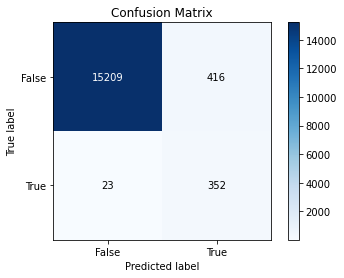

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS1_y_test, DS1_pred_rf, normalize=False)
plt.show()

Por lo tanto, se toma ese modelo como base.

In [ ]:
# Se recuerda
rfc1

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 120}, criterion='gini',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=400, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

ROC y AUC para el modelo:

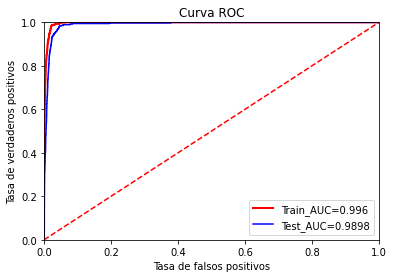

In [ ]:
rf_pred_prob_tr = rfc1.predict_proba(DS1_x_train_scaled)
rf_pred_prob_te = rfc1.predict_proba(DS1_x_test_scaled)

fpr_tr, tpr_tr, thresholds_tr = roc_curve(DS1_y_train, rf_pred_prob_tr[:,1])
fpr_te, tpr_te, thresholds_te = roc_curve(DS1_y_test, rf_pred_prob_te[:,1])

roc_auc_tr = auc(fpr_tr, tpr_tr)
roc_auc_te = auc(fpr_te, tpr_te)

plt.plot(fpr_tr, tpr_tr, 'r', linewidth=2.0, label='Train_AUC=%0.3f' % roc_auc_tr)
plt.plot(fpr_te, tpr_te, 'b', label='Test_AUC=%0.4f' % roc_auc_te)

plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Cálculo del umbral (*threshold*) óptimo

In [ ]:
rf_best_threshold, rf_min_cost, rf_thres, rf_costs, rf_precs, rf_recs = fun_thresh(thresholds_te, DS1_y_test, rf_pred_prob_te)

100%|██████████| 1441/1441 [00:22<00:00, 64.40it/s]


In [ ]:
print("El mejor umbral es:", rf_best_threshold, "y su coste mínimo asociado:", rf_min_cost)

El mejor umbral es: 0.20986747812945591 y su coste mínimo asociado: 10710


Representación del coste, la precisión y el *recall* en función del umbral:

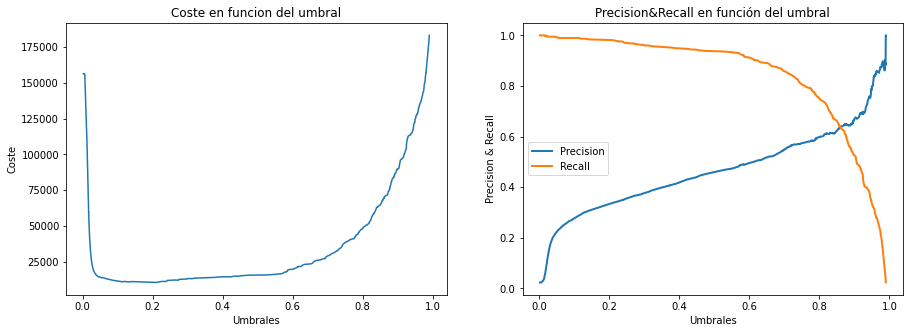

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(rf_thres, rf_costs)   
plt.xlabel('Umbrales')
plt.ylabel('Coste')
plt.title("Coste en funcion del umbral")

plt.subplot(1,2,2)
plt.plot(rf_thres, rf_precs, label='Precision', linestyle = 'solid', linewidth = 2)
plt.plot(rf_thres, rf_recs, label='Recall', linestyle = 'solid', linewidth = 2)
plt.xlabel("Umbrales")
plt.ylabel("Precision & Recall")
plt.title("Precision&Recall en función del umbral")
plt.legend()

plt.show()

Predicciones utilizando el umbral óptimo:

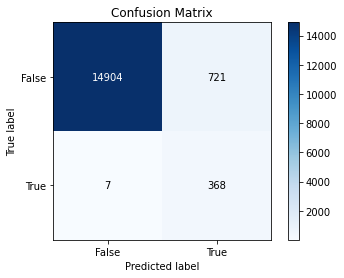

In [ ]:
rf_pred_final = rfc1.predict_proba(DS1_x_test_scaled)[:,1] > rf_best_threshold

# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS1_y_test, rf_pred_final, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS1_y_test, rf_pred_final))

Coste total del modelo: 10710


Medidas sobre el modelo definitivo:

In [ ]:
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS1_y_test, rf_pred_final), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS1_y_test, rf_pred_final), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS1_y_test, rf_pred_final), 4))
print("Exactitud (accuracy) en los datos de prueba:", np.round(accuracy_score(DS1_y_test, rf_pred_final), 4))
print("ROC AUC score en los datos de prueba:", np.round(roc_auc_score(DS1_y_test, rf_pred_final), 4))

Precisión (precision) en los datos de prueba: 0.3379
Exhaustividad (recall) en los datos de prueba: 0.9813
Valor-F (F1-score) en los datos de prueba: 0.5027
Exactitud (accuracy) en los datos de prueba: 0.9545
ROC AUC score en los datos de prueba: 0.9676


# 2. **DS2**

## 2.1. Random Forest

En primer lugar se estandarizan las características utilizando `MinMaxScaler`:

In [ ]:
scaler = MinMaxScaler()
DS2_x_train_scaled = scaler.fit_transform(DS2_x_train)
DS2_x_test_scaled = scaler.transform(DS2_x_test)

In [ ]:
# Se selecciona una muestra aleatoria de 20000 muestras para lograr una validación cruzada más rápida
idx = random.sample(range(DS2_x_train.shape[0]), 20000)
DS2_x_train_scaled_sampled = DS2_x_train_scaled[idx]
DS2_y_train_sampled = DS2_y_train['class'][idx]

In [ ]:
# Peso mayor para la clase 1
weights = [(1,120), (1,100), (1,50), (1,10)]

grid = {"criterion": ['gini', 'entropy'],
        "max_features": ['sqrt', 'log2'],
        "n_estimators": [100,200,250,300,400,500],
        "max_depth": [10,15,20],
        "class_weight": [{0: w[0], 1: w[1]} for w in weights]
        }

clf = RandomForestClassifier(n_jobs=-1, random_state=0)

grid_cv = GridSearchCV(estimator=clf,
                       param_grid=grid,
                       scoring=score,
                       cv=3,
                       n_jobs=-1,
                       verbose=10
                       )

In [ ]:
cv_rf = grid_cv.fit(DS2_x_train_scaled_sampled, DS2_y_train_sampled)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 12

In [ ]:
cv_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 20}, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [ ]:
cv_rf.best_params_

{'class_weight': {0: 1, 1: 20},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [ ]:
cv_rf.best_score_

-16666.666666666668

In [ ]:
# Modelo
rfc2 = RandomForestClassifier(n_estimators=200,
                              max_features='sqrt',
                              max_depth=10,
                              criterion='gini',
                              class_weight={0: 1, 1: 10},
                              n_jobs=-1,
                              random_state=0)

rfc2.fit(DS2_x_train_scaled, np.ravel(DS2_y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 10}, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

Medidas sobre los conjuntos de entrenamiento y prueba:

In [ ]:
DS2_pred_rf_train = rfc2.predict(DS2_x_train_scaled)
print("Pérdida en los datos de entrenamiento:", cost_function(DS2_y_train, DS2_pred_rf_train))
print("Precisión (precision) en los datos de entrenamiento:", np.round(precision_score(DS2_y_train, DS2_pred_rf_train), 4))
print("Sensibilidad (recall) en los datos de entrenamiento:", np.round(recall_score(DS2_y_train, DS2_pred_rf_train), 4))
print("Valor-F1 (F1-score) en los datos de entrenamiento:", np.round(f1_score(DS2_y_train, DS2_pred_rf_train), 4))

DS2_pred_rf = rfc2.predict(DS2_x_test_scaled)
print("\nPérdida en los datos de prueba:", cost_function(DS2_y_test, DS2_pred_rf))
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS2_y_test, DS2_pred_rf), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS2_y_test, DS2_pred_rf), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS2_y_test, DS2_pred_rf), 4))

Pérdida en los datos de entrenamiento: 12760
Precisión (precision) en los datos de entrenamiento: 0.8827
Sensibilidad (recall) en los datos de entrenamiento: 0.9597
Valor-F1 (F1-score) en los datos de entrenamiento: 0.9196

Pérdida en los datos de prueba: 59630
Precisión (precision) en los datos de prueba: 0.8031
Sensibilidad (recall) en los datos de prueba: 0.6853
Valor-F1 (F1-score) en los datos de prueba: 0.7396


Matriz de confusión para el umbral por defecto de 0,5:

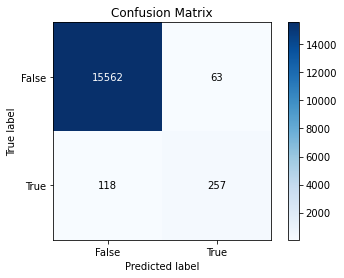

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS2_y_test, DS2_pred_rf, normalize=False)
plt.show()

Por lo tanto, se toma ese modelo como base.

In [ ]:
# Se recuerda
rfc2

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 10}, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

ROC y AUC para el modelo:

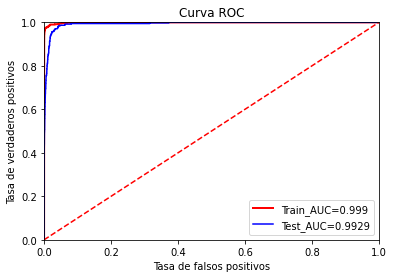

In [ ]:
rf_pred_prob_tr = rfc2.predict_proba(DS2_x_train_scaled)
rf_pred_prob_te = rfc2.predict_proba(DS2_x_test_scaled)

fpr_tr, tpr_tr, thresholds_tr = roc_curve(DS2_y_train, rf_pred_prob_tr[:,1])
fpr_te, tpr_te, thresholds_te = roc_curve(DS2_y_test, rf_pred_prob_te[:,1])

roc_auc_tr = auc(fpr_tr, tpr_tr)
roc_auc_te = auc(fpr_te, tpr_te)

plt.plot(fpr_tr, tpr_tr, 'r', linewidth=2.0, label='Train_AUC=%0.3f' % roc_auc_tr)
plt.plot(fpr_te, tpr_te, 'b', label='Test_AUC=%0.4f' % roc_auc_te)

plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Cálculo del umbral (*threshold*) óptimo

In [ ]:
rf_best_threshold, rf_min_cost, rf_thres, rf_costs, rf_precs, rf_recs = fun_thresh(thresholds_te, DS2_y_test, rf_pred_prob_te)

100%|██████████| 2551/2551 [00:40<00:00, 63.76it/s]


In [ ]:
print("El mejor umbral es:", rf_best_threshold, "y su coste mínimo asociado:", rf_min_cost)

El mejor umbral es: 0.0573085435543713 y su coste mínimo asociado: 9800


Representación del coste, la precisión y el *recall* en función del umbral:

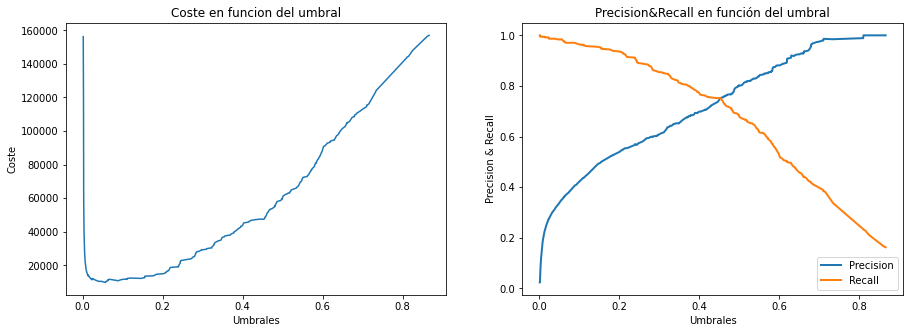

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(rf_thres, rf_costs)   
plt.xlabel('Umbrales')
plt.ylabel('Coste')
plt.title("Coste en funcion del umbral")

plt.subplot(1,2,2)
plt.plot(rf_thres, rf_precs, label='Precision', linestyle = 'solid', linewidth = 2)
plt.plot(rf_thres, rf_recs, label='Recall', linestyle = 'solid', linewidth = 2)
plt.xlabel("Umbrales")
plt.ylabel("Precision & Recall")
plt.title("Precision&Recall en función del umbral")
plt.legend()

plt.show()

Predicciones utilizando el umbral óptimo:

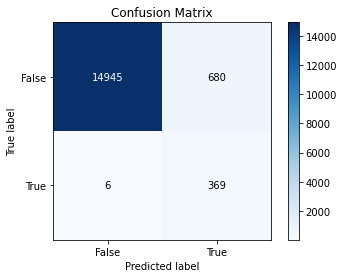

In [ ]:
rf_pred_final = rfc2.predict_proba(DS2_x_test_scaled)[:,1] > rf_best_threshold

# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS2_y_test, rf_pred_final, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS2_y_test, rf_pred_final))

Coste total del modelo: 9800


Medidas sobre el modelo definitivo:

In [ ]:
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS2_y_test, rf_pred_final), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS2_y_test, rf_pred_final), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS2_y_test, rf_pred_final), 4))
print("Exactitud (accuracy) en los datos de prueba:", np.round(accuracy_score(DS2_y_test, rf_pred_final), 4))
print("ROC AUC score en los datos de prueba:", np.round(roc_auc_score(DS2_y_test, rf_pred_final), 4))

Precisión (precision) en los datos de prueba: 0.3518
Sensibilidad (recall) en los datos de prueba: 0.984
Valor-F1 (F1-score) en los datos de prueba: 0.5183
Exactitud (accuracy) en los datos de prueba: 0.9571
ROC AUC score en los datos de prueba: 0.9702


# 3. **DS3**

## 3.1. Random Forest

En primer lugar se estandarizan las características utilizando `MinMaxScaler`:

In [ ]:
scaler = MinMaxScaler()
DS3_x_train_scaled = scaler.fit_transform(DS3_x_train)
DS3_x_test_scaled = scaler.transform(DS3_x_test)

In [ ]:
# Se selecciona una muestra aleatoria de 20000 muestras para lograr una validación cruzada más rápida
idx = random.sample(range(DS3_x_train.shape[0]), 20000)
DS3_x_train_scaled_sampled = DS3_x_train_scaled[idx]
DS3_y_train_sampled = DS3_y_train['class'][idx]

In [ ]:
# Peso mayor para la clase 1
weights = [(1,50), (1,20), (1,10), (1,2)]

grid = {"criterion": ['gini', 'entropy'],
        "max_features": ['sqrt', 'log2'],
        "n_estimators": [100,200,250,300,400,500],
        "max_depth": [10,15,20],
        "class_weight": [{0: w[0], 1: w[1]} for w in weights]
        }

clf = RandomForestClassifier(n_jobs=-1, random_state=0)

grid_cv = GridSearchCV(estimator=clf,
                       param_grid=grid,
                       scoring=score,
                       cv=3,
                       n_jobs=-1,
                       verbose=10
                       )

In [ ]:
cv_rf = grid_cv.fit(DS3_x_train_scaled_sampled, DS3_y_train_sampled)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 23

In [ ]:
cv_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
cv_rf.best_params_

{'class_weight': {0: 1, 1: 2},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'n_estimators': 250}

In [ ]:
cv_rf.best_score_

-18606.666666666668

In [ ]:
# Modelo
rfc3 = RandomForestClassifier(n_estimators=250,
                              max_features='log2',
                              max_depth=10,
                              criterion='gini',
                              class_weight={0: 1, 1: 2},
                              n_jobs=-1,
                              random_state=0)

rfc3.fit(DS3_x_train_scaled, np.ravel(DS3_y_train))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Medidas sobre los conjuntos de entrenamiento y prueba:

In [ ]:
DS3_pred_rf_train = rfc3.predict(DS3_x_train_scaled)
print("Pérdida en los datos de entrenamiento:", cost_function(DS3_y_train, DS3_pred_rf_train))
print("Precisión (precision) en los datos de entrenamiento:", np.round(precision_score(DS3_y_train, DS3_pred_rf_train), 4))
print("Sensibilidad (recall) en los datos de entrenamiento:", np.round(recall_score(DS3_y_train, DS3_pred_rf_train), 4))
print("Valor-F1 (F1-score) en los datos de entrenamiento:", np.round(f1_score(DS3_y_train, DS3_pred_rf_train), 4))

DS3_pred_rf = rfc3.predict(DS3_x_test_scaled)
print("\nPérdida en los datos de prueba:", cost_function(DS3_y_test, DS3_pred_rf))
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS3_y_test, DS3_pred_rf), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS3_y_test, DS3_pred_rf), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS3_y_test, DS3_pred_rf), 4))

Pérdida en los datos de entrenamiento: 105040
Precisión (precision) en los datos de entrenamiento: 0.9665
Sensibilidad (recall) en los datos de entrenamiento: 0.9931
Valor-F1 (F1-score) en los datos de entrenamiento: 0.9796

Pérdida en los datos de prueba: 27920
Precisión (precision) en los datos de prueba: 0.426
Sensibilidad (recall) en los datos de prueba: 0.8747
Valor-F1 (F1-score) en los datos de prueba: 0.5729


Matriz de confusión para el umbral por defecto de 0,5:

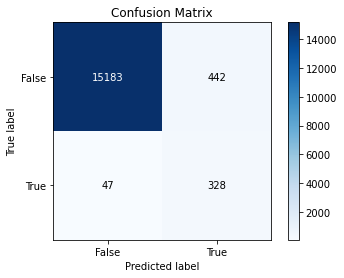

In [ ]:
# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS3_y_test, DS3_pred_rf, normalize=False)
plt.show()

Por lo tanto, se toma ese modelo como base.

In [ ]:
# Se recuerda
rfc3

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=10, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

ROC y AUC para el modelo:

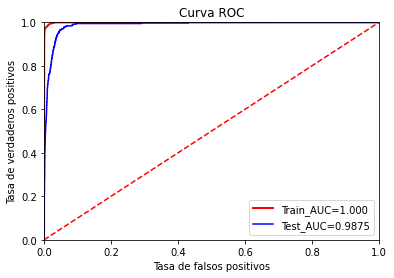

In [ ]:
rf_pred_prob_tr = rfc3.predict_proba(DS3_x_train_scaled)
rf_pred_prob_te = rfc3.predict_proba(DS3_x_test_scaled)

fpr_tr, tpr_tr, thresholds_tr = roc_curve(DS3_y_train, rf_pred_prob_tr[:,1])
fpr_te, tpr_te, thresholds_te = roc_curve(DS3_y_test, rf_pred_prob_te[:,1])

roc_auc_tr = auc(fpr_tr, tpr_tr)
roc_auc_te = auc(fpr_te, tpr_te)

plt.plot(fpr_tr, tpr_tr, 'r', linewidth=2.0, label='Train_AUC=%0.3f' % roc_auc_tr)
plt.plot(fpr_te, tpr_te, 'b', label='Test_AUC=%0.4f' % roc_auc_te)

plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

Cálculo del umbral (*threshold*) óptimo

In [ ]:
rf_best_threshold, rf_min_cost, rf_thres, rf_costs, rf_precs, rf_recs = fun_thresh(thresholds_te, DS3_y_test, rf_pred_prob_te)

100%|██████████| 1582/1582 [00:23<00:00, 66.75it/s]


In [ ]:
print("El mejor umbral es:", rf_best_threshold, "y su coste mínimo asociado:", rf_min_cost)

El mejor umbral es: 0.1596727705406408 y su coste mínimo asociado: 13580


Representación del coste, la precisión y el *recall* en función del umbral:

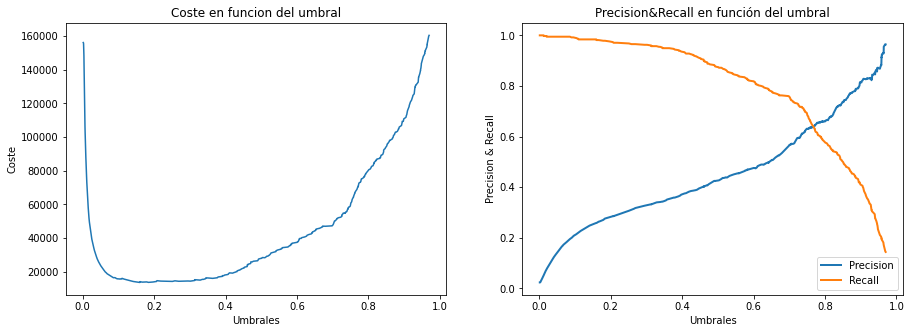

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(rf_thres, rf_costs)   
plt.xlabel('Umbrales')
plt.ylabel('Coste')
plt.title("Coste en funcion del umbral")

plt.subplot(1,2,2)
plt.plot(rf_thres, rf_precs, label='Precision', linestyle = 'solid', linewidth = 2)
plt.plot(rf_thres, rf_recs, label='Recall', linestyle = 'solid', linewidth = 2)
plt.xlabel("Umbrales")
plt.ylabel("Precision & Recall")
plt.title("Precision&Recall en función del umbral")
plt.legend()

plt.show()

Predicciones utilizando el umbral óptimo:

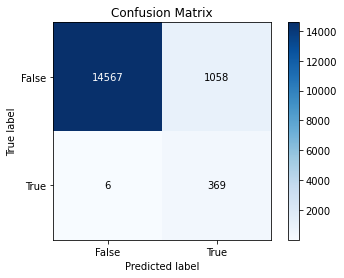

In [ ]:
rf_pred_final = rfc3.predict_proba(DS3_x_test_scaled)[:,1] > rf_best_threshold

# Confusion matrix
skplt.metrics.plot_confusion_matrix(DS3_y_test, rf_pred_final, normalize=False)
plt.show()

In [ ]:
# Coste total
print("Coste total del modelo:", cost_function(DS3_y_test, rf_pred_final))

Coste total del modelo: 13580


Medidas sobre el modelo definitivo:

In [ ]:
print("Precisión (precision) en los datos de prueba:", np.round(precision_score(DS3_y_test, rf_pred_final), 4))
print("Sensibilidad (recall) en los datos de prueba:", np.round(recall_score(DS3_y_test, rf_pred_final), 4))
print("Valor-F1 (F1-score) en los datos de prueba:", np.round(f1_score(DS3_y_test, rf_pred_final), 4))
print("Exactitud (accuracy) en los datos de prueba:", np.round(accuracy_score(DS3_y_test, rf_pred_final), 4))
print("ROC AUC score en los datos de prueba:", np.round(roc_auc_score(DS3_y_test, rf_pred_final), 4))

Precisión (precision) en los datos de prueba: 0.2586
Sensibilidad (recall) en los datos de prueba: 0.984
Valor-F1 (F1-score) en los datos de prueba: 0.4095
Exactitud (accuracy) en los datos de prueba: 0.9335
ROC AUC score en los datos de prueba: 0.9581
